> E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

With context size `4`, embedding size `15`, and dynamic learning rate (`0.5` for 1~5000 epochs and `0.1` for 5001~25000 epochs), the validation loss was get down to `2.19` 😨

|  | train | test | dev |
| --- | --- | --- | --- |
| reproduce | `2.1644` | `2.2246` | `2.2191` |
| tuned | `2.1457` | `2.1999` | `2.1951` |

> E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

> E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [45]:
import torch

if torch.backends.mps.is_available():
    # not sure why, the mps device is even slower than the cpu device on my MacBook m1 machine
    # device = torch.device('mps')
    device = torch.device('cpu')
else:
    device = torch.device('cpu')

device

device(type='cpu')

# Load data

In [2]:
words = open('../../../data/names.txt', 'r').read().splitlines()

In [3]:
g = torch.Generator().manual_seed(2147483647)
trainwords, devwords, testwords = torch.utils.data.random_split(words, [0.8, 0.1, 0.1])

In [4]:
class Dataset:
    def __init__(self, dataset, context_size: int = 3):
        # create character - index mapping
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        # digitize the dataset
        xs, ys = [], []

        for w in dataset:
            context = [0] * context_size

            for ch in w + '.':
                ix = self.stoi[ch]
                xs.append(context)
                ys.append(ix)
                context = context[1:] + [ix]

        self.xs = torch.tensor(xs, device=device)
        self.ys = torch.tensor(ys, device=device)

    def __len__(self):
        return len(self.xs)
    
    def draw(self, batch_size: int = 32):
        ix = torch.randint(0, len(self), (batch_size,))
        return(self.xs[ix], self.ys[ix])

# Multilayer perceptron

In [50]:
import sys

def progress_bar(percent: float, bar_len: int = 20, front_str: str = '', back_str: str = ''):
    sys.stdout.write("\r")
    sys.stdout.write("{}[{:<{}}] {:.1%}{}".format(front_str, "=" * int(bar_len * percent), bar_len, percent, back_str))
    sys.stdout.flush()
    # avoiding '%' appears when progress completed
    if percent == 1:
        print()

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def loss_curve(loss_ls):
    plt.plot(np.reshape(loss_ls, (-1,)))
    plt.xlabel('epoch')
    plt.ylabel('cross entropy')
    plt.grid('--')

In [56]:
import torch.nn.functional as F

class MLP_LM:
    def __init__(self, context_size: int = 3, embed_size: int = 10, hidden_size: int = 200):
        self.input_size = context_size * embed_size

        g = torch.Generator().manual_seed(2147483647)

        self.C = torch.randn((27, embed_size), generator=g).to(device)
        self.W1 = torch.randn((self.input_size, hidden_size), generator=g).to(device)
        self.b1 = torch.randn((hidden_size), generator=g).to(device)
        self.W2 = torch.randn((hidden_size, 27), generator=g).to(device)
        self.b2 = torch.randn((27), generator=g).to(device)
        self.param = [self.C, self.W1, self.W2, self.b1, self.b2]

    def forward(self, xs):
        emb = self.C[xs]
        h = torch.tanh(emb.view(-1, self.input_size) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def train(self, dataset, batch_size: int = 32, epochs: int = 10, lr: float = 1e-1):
        for p in self.param:
            p.requires_grad = True

        loss_ls = []

        for ix in range(epochs):
            progress_bar((ix+1) / epochs, back_str="\t learning rate {}".format(lr))

            # batch forward/backward pass
            xs_batch, ys_batch = dataset.draw(batch_size)
            logits = self.forward(xs_batch)
            loss = F.cross_entropy(logits, ys_batch)
            loss_ls.append(loss.item())

            # gradient descent
            for p in self.param:
                p.grad = None
            
            loss.backward()

            for p in self.param:
                p.data += -lr * p.grad

        return loss_ls

    def eval(self, dataset, loss_str: str = ''):
        xs, ys = dataset.xs, dataset.ys
        logits = self.forward(xs)
        loss = F.cross_entropy(logits, ys)
        print("{} \t {:.4f}".format(loss_str, loss.item()))

# Hyper parameters

[====================] 100.0%	 learning rate 0.5
train 	 2.8180
dev 	 2.8617
test 	 2.8697
[====================] 100.0%	 learning rate 0.1
train 	 2.2855
dev 	 2.3286
test 	 2.3204
[====================] 100.0%	 learning rate 0.05
train 	 2.2692
dev 	 2.3114
test 	 2.3052
[====================] 100.0%	 learning rate 0.01
train 	 2.2646
dev 	 2.3067
test 	 2.3004
[====================] 100.0%	 learning rate 0.005
train 	 2.2634
dev 	 2.3057
test 	 2.2987


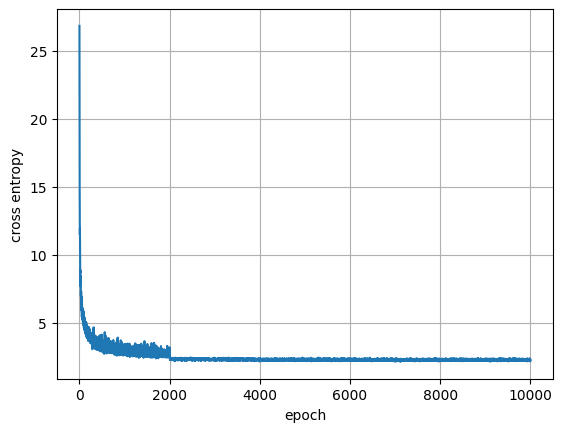

In [63]:
# dataset
context_size = 3
trainset = Dataset(trainwords, context_size=context_size)
devset = Dataset(devwords, context_size=context_size)
testset = Dataset(testwords, context_size=context_size)

# model init
lm = MLP_LM(
    context_size = context_size,
    embed_size = 10,
    hidden_size = 200,
    )

# train
loss_ls = []

for lr in [5e-1, 1e-1, 5e-2, 1e-2, 5e-3]:
    loss_ls.append(lm.train(trainset, epochs=2000, batch_size=1000, lr=lr))

    # eval
    lm.eval(trainset, loss_str='train')
    lm.eval(devset, loss_str='dev')
    lm.eval(testset, loss_str='test')
    
loss_curve(loss_ls)


[====================] 100.0%	 learning rate 0.5
train 	 2.9565
dev 	 3.0231
test 	 3.0306
[====================] 100.0%	 learning rate 0.1
train 	 2.2046
dev 	 2.2656
test 	 2.2596
[====================] 100.0%	 learning rate 0.1
train 	 2.1856
dev 	 2.2456
test 	 2.2413
[====================] 100.0%	 learning rate 0.1
train 	 2.1748
dev 	 2.2336
test 	 2.2292
[====================] 100.0%	 learning rate 0.1
train 	 2.1644
dev 	 2.2246
test 	 2.2191


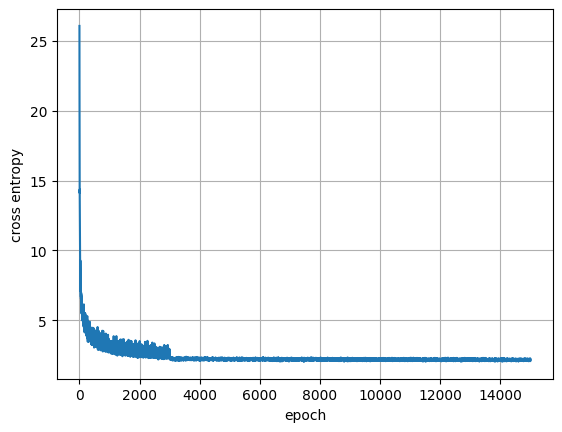

In [70]:
# dataset
context_size = 3
trainset = Dataset(trainwords, context_size=context_size)
devset = Dataset(devwords, context_size=context_size)
testset = Dataset(testwords, context_size=context_size)

# model init
lm = MLP_LM(
    context_size = context_size,
    embed_size = 15,
    hidden_size = 200,
    )

# train
loss_ls = []

for lr in [5e-1, 1e-1, 1e-1, 1e-1, 1e-1]:
    loss_ls.append(lm.train(trainset, epochs=3000, batch_size=1000, lr=lr))
    
    # eval
    lm.eval(trainset, loss_str='train')
    lm.eval(devset, loss_str='dev')
    lm.eval(testset, loss_str='test')

loss_curve(loss_ls)

[====================] 100.0%	 learning rate 0.5
train 	 2.5204
dev 	 2.5752
test 	 2.5608
[====================] 100.0%	 learning rate 0.1
train 	 2.1828
dev 	 2.2324
test 	 2.2274
[====================] 100.0%	 learning rate 0.1
train 	 2.1686
dev 	 2.2217
test 	 2.2153
[====================] 100.0%	 learning rate 0.1
train 	 2.1564
dev 	 2.2111
test 	 2.2039
[====================] 100.0%	 learning rate 0.1
train 	 2.1457
dev 	 2.1999
test 	 2.1951


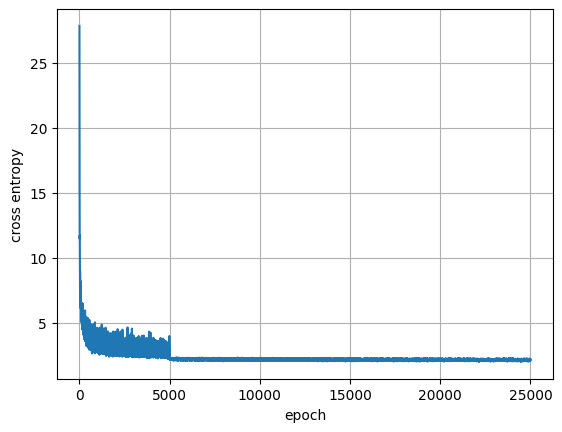

In [72]:
# dataset
context_size = 4
trainset = Dataset(trainwords, context_size=context_size)
devset = Dataset(devwords, context_size=context_size)
testset = Dataset(testwords, context_size=context_size)

# model init
lm = MLP_LM(
    context_size = context_size,
    embed_size = 15,
    hidden_size = 200,
    )

# train
loss_ls = []

for lr in [5e-1, 1e-1, 1e-1, 1e-1, 1e-1]:
    loss_ls.append(lm.train(trainset, epochs=5000, batch_size=1000, lr=lr))
    
    # eval
    lm.eval(trainset, loss_str='train')
    lm.eval(devset, loss_str='dev')
    lm.eval(testset, loss_str='test')

loss_curve(loss_ls)